# Predicting bacteriophage hosts on the basis of receptor-binding protein data

In this notebook, several machine learning methods are applied to train models that predict bacteriophage hosts on the basis of receptor-binding protein (RBP) sequence data from ESKAPE-related phages (and additionally E.coli, S. enterica and C. difficile).

0. Import libraries: needed software packages 
1. Data exploration / preprocessing
2. Feature construction: compute relevant descriptors of the protein and CDS sequences for machine learning applications

4. Training and cross-validation: train different models and evaluate them
5. Feature importance: investigate which features are most important in the classification
6. Benchmarking with BLAST: compare machine learning with standard BLAST output.

## 0. Import libraries

In [36]:
import os
import time
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import RBP_functions as RBP_f
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline
from Bio.Blast import NCBIXML
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.exceptions import DataConversionWarning
from Bio.Blast.Applications import NcbiblastpCommandline
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, GroupKFold, cross_val_score, cross_val_predict, train_test_split, StratifiedShuffleSplit, LeaveOneGroupOut
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, make_scorer, auc, roc_curve, confusion_matrix, f1_score, precision_score, recall_score, precision_recall_curve

## 1. Data exploration & preprocessing

In [2]:
fibers = pd.read_csv('RBP_database.csv', delimiter=',', header=0, names=['id', 'tax_id', 'embl_id', 'name', 'protein_sequence', 'dna_sequence', 'org', 'host', 'protein_length', 'protein_200'])
print(fibers.shape)
fibers.head()

(1232, 10)


,id,tax_id,embl_id,name,protein_sequence,dna_sequence,org,host,protein_length,protein_200
0,Q04830,344021,AJ505988,Tail spike protein,MSTITQFPSGNTQYRIEFDYLARTFVVVTLVNSSNPTLNRVLEVGR...,ATGTCCACGATTACACAATTCCCTTCAGGAAACACTCAGTACAGGA...,Bacteriophage K1F,Escherichia coli,1064,MSTITQFPSGNTQYRIEFDYLARTFVVVTLVNSSNPTLNRVLEVGR...
1,Q9XJP3,10761,AF128887,Tail spike protein,MTDIITNVVIGMPSQLFTMARSFKAVANGKIYIGKIDTDPVNPENQ...,ATGACAGACATTATAACCAATGTTGTAATTGGGATGCCTTCGCAAC...,Bacteriophage SfVI,Shigella flexneri,623,MTDIITNVVIGMPSQLFTMARSFKAVANGKIYIGKIDTDPVNPENQ...
2,P13390,10726,AM084272,L-shaped tail fiber protein pb1,MAITKIILQQMVTMDQNSITASKYPKYTVVLSNSISSITAADVTSA...,ATGGCTATAACTAAAATAATTCTACAGCAAATGGTCACTATGGACC...,Enterobacteria phage T5,Escherichia coli,1396,MAITKIILQQMVTMDQNSITASKYPKYTVVLSNSISSITAADVTSA...
3,P12528,10754,J02473,Tail spike protein,MTDITANVVVSNPRPIFTESRSFKAVANGKIYIGQIDTDPVNPANQ...,GAATTCTCGTACATCATTGGAATAGCGAGAGACGTTTTAATTAATC...,Bacteriophage P22,Salmonella enterica,667,MTDITANVVVSNPRPIFTESRSFKAVANGKIYIGQIDTDPVNPANQ...
4,P49714,344022,Z36986,Tail spike protein,MIQRLGSSLVKFKSKIAGAIWRNLDDKLTEVVSLKDFGAKGDGKTN...,ATGATTCAAAGACTAGGTTCTTCATTAGTTAAATTCAAGAGTAAAA...,Bacteriophage K1E,Escherichia coli,811,MIQRLGSSLVKFKSKIAGAIWRNLDDKLTEVVSLKDFGAKGDGKTN...


Make bar plot and encode dummies (labels) for classification later on. We discard entities related to Enterococcus faecium and Enterobacter, due to shortage of data.

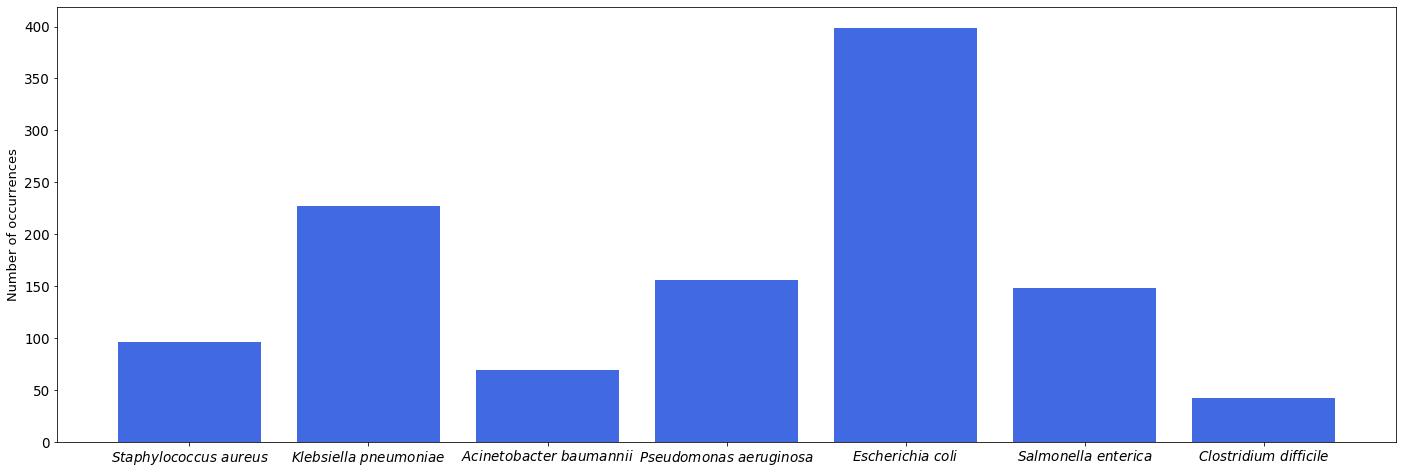

[96, 227, 69, 156, 399, 148, 42]


In [3]:
# Bar plot of hosts and dummy coding
c_entero = 0; c_staph = 0; c_klebs = 0; c_acineto = 0; c_pseudo = 0; c_clos = 0; c_ecoli = 0; c_salmonella = 0; c_ent = 0; others = 0
dummies = []
for i,item in enumerate(fibers.iloc[:, 7]):
    #if 'Enterococcus faecium' in item:
    #    c_entero += 1
    if 'Staphylococcus aureus' in item:
        c_staph += 1
        dummies.append(0)
    elif 'Klebsiella pneumoniae' in item:
        c_klebs += 1
        dummies.append(1)
    elif 'Acinetobacter baumannii' in item:
        c_acineto += 1
        dummies.append(2)
    elif 'Pseudomonas aeruginosa' in item:
        c_pseudo += 1
        dummies.append(3)
    #elif 'Enterobacter cloacae' in item:
    #    c_ent += 1
    elif 'Escherichia coli' in item:
        c_ecoli += 1
        dummies.append(4)
    elif 'Salmonella enterica' in item:
        c_salmonella += 1
        dummies.append(5)
    elif 'Clostridium difficile' in item:
        c_clos += 1
        dummies.append(6)
    else:
        others += 1
        dummies.append(7)

fig, ax = plt.subplots(figsize=(24,8))
plt.bar(np.arange(0,7), [c_staph, c_klebs, c_acineto, c_pseudo, c_ecoli, c_salmonella, c_clos], color='royalblue')
plt.xticks(np.arange(0,7), ['$\it{Staphylococcus\ aureus}$', '$\it{Klebsiella\ pneumoniae}$', '$\it{Acinetobacter\ baumannii}$', '$\it{Pseudomonas\ aeruginosa}$', '$\it{Escherichia\ coli}$', '$\it{Salmonella\ enterica}$', '$\it{Clostridium\ difficile}$'])
ax.set_ylabel('Number of occurrences', fontsize=13)
plt.tick_params(labelsize=13.5)
plt.show(block=False)
print([c_staph, c_klebs, c_acineto, c_pseudo, c_ecoli, c_salmonella, c_clos])

In [4]:
# restrict dataset to classes 0-6 (all but 'others' class -> seven-class classification)
fibers['class'] = np.asarray(dummies)
fibers = fibers.loc[fibers['class'] != 7]
dummies = [item for item in dummies if item != 7]
fibers.reset_index(drop=True, inplace=True)
print(len(dummies), fibers.shape)

1137 (1137, 11)


In [5]:
# check alignment identities and db size
alignment_scores = np.loadtxt('/Users/Dimi/Documents/GitHub_Local/BacteriophageHostPrediction/RBP_alignmentscores.txt')
np.fill_diagonal(alignment_scores, 0)
identity_threshold = [0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 0.99, 1]
db_size = []
for threshold in identity_threshold:
    to_delete = []
    for i in range(alignment_scores.shape[0]):
        for j in range(i, alignment_scores.shape[1]):
            if (alignment_scores[i,j] >= threshold) & (i not in to_delete) & (j not in to_delete):
                to_delete.append(j)
                        
    db_size.append(1137-len(to_delete))

#fig, ax = plt.subplots(figsize=(12,8))
#identity_percentage = [i * 100 for i in identity_threshold]
#ax.plot(identity_percentage, db_size)
#ax.set_xlabel('Identity percentage threshold')
#ax.set_ylabel('Number of sequences in database')
#fig.savefig('threshold_vs_databasesize.png', dpi=400)

##### Heat- and clustermap of alignment identities

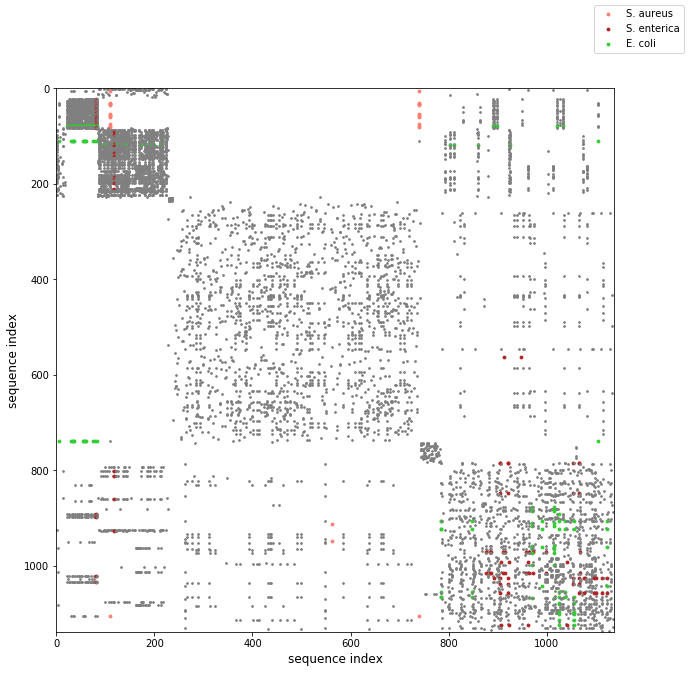

In [6]:
# Sequence pairs > 0.95 identity
# matrix is symmetrical, so we can see among which species the identicals are confused by looking at the
# corresponding row and columns.
cross_species = {}
colors = ['salmon', 'gold', 'plum', 'lightskyblue', 'limegreen', 'firebrick', 'royalblue']
labels = ['S. aureus', 'K. pneumoniae', 'A. baumannii', 'P. aeruginosa', 'E. coli', 'S. enterica', 'C. difficile']
threshold = 0.95
fig, ax = plt.subplots(figsize=(10,10))
ax.set_xlim(0, 1138)
ax.set_ylim(1138, 0)
for i in range(alignment_scores.shape[0]):
    for j in range(alignment_scores.shape[1]): 
        if (alignment_scores[i,j] >= threshold) & (dummies[i] == dummies[j]):
            ax.scatter(j, i, c='grey', s=3)
            
        elif (alignment_scores[i,j] >= threshold) & (dummies[i] != dummies[j]):
            ax.scatter(j, i, c=colors[dummies[j]], s=8, label=labels[dummies[j]])
            
            # add to dict for later analyses
            if i in cross_species.keys():
                cross_species[i].append(j)
            else:
                cross_species[i] = [j]
            
#row_indices = []
#for item in cross_species:
#    if (cross_species.count(item) >= 2) & (item not in row_indices):
#        row_indices.append(item)
#        ax.axvline(item, lw=0.5, color=colors[dummies[item]])

ax.set_xlabel('sequence index', size=12)
ax.set_ylabel('sequence index', size=12)
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
fig.legend(by_label.values(), by_label.keys())
#fig.tight_layout()
#fig.savefig('alignments_scatter.png', dpi=400)

/opt/anaconda3/lib/python3.7/site-packages/seaborn/matrix.py:624: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/opt/anaconda3/lib/python3.7/site-packages/seaborn/matrix.py:595: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


<Figure size 1008x1008 with 0 Axes>

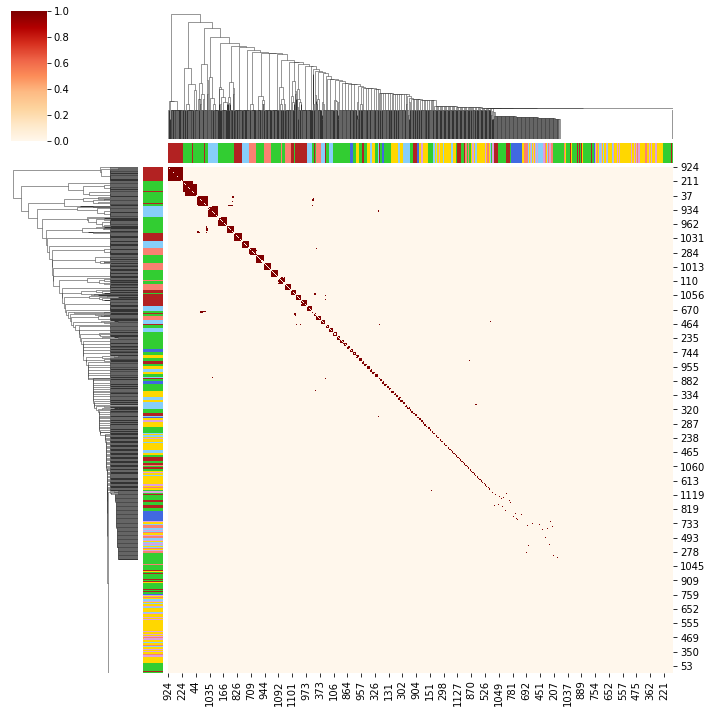

In [7]:
# Cluster map
thres = 1*(alignment_scores >= 0.95)
color = []
for i, cl in enumerate(dummies):
    if cl == 0:
        color.append('salmon')
    elif cl == 1:
        color.append('gold')
    elif cl == 2:
        color.append('plum')
    elif cl == 3:
        color.append('lightskyblue')
    elif cl == 4:
        color.append('limegreen')
    elif cl == 5:
        color.append('firebrick')
    elif cl == 6:
        color.append('royalblue')
        
plt.figure(figsize=(14,14))
fig = sns.clustermap(thres, row_colors=color, col_colors=color, cmap='OrRd')
#fig.savefig('alignments_clustermap.png', dpi=400)

In [8]:
# Delete identicals
to_delete = []
for i in range(fibers.shape[0]):
    sequence1 = list(fibers['protein_sequence'])[i]
    for j in range(i, fibers.shape[0]):
        sequence2 = list(fibers['protein_sequence'])[j]
        if (sequence1 == sequence2) & (i != j) & (i not in to_delete) & (j not in to_delete):
            to_delete.append(j)

to_delete.sort(reverse=True)
for i in to_delete:
    fibers = fibers.drop(index = i)
    del dummies[i]
    
fibers.reset_index(drop=True, inplace=True)
print(len(dummies), fibers.shape)

887 (887, 11)


In [9]:
# delete identicals from alignment_scores matrix (before making groups)
for i in to_delete:
    alignment_scores = np.delete(alignment_scores, i, 0)
    alignment_scores = np.delete(alignment_scores, i, 1)

## 2. Feature construction and further preprocessing

The functions for feature construction are implemented in the accompanying Python script 'RBP_functions.py'. This script is imported at the beginning of this notebook.

##### Calculate DNA features on both parts

In [10]:
dna_list = list(fibers.iloc[:,5])
dna_feats = RBP_f.dna_features(dna_list)

##### Calculate protein features on both parts

In [11]:
protein_list = list(fibers.iloc[:,4])
protein_feats = RBP_f.protein_features(protein_list)

In [12]:
# protein features: CTD & Z-scale
extra_feats = np.zeros((len(dummies), 47))

for i,item in enumerate(fibers.iloc[:,4]):
    feature_lst = []
    feature_lst  += RBP_f.CTDC(item)
    feature_lst += RBP_f.CTDT(item)
    feature_lst += RBP_f.zscale(item)
    extra_feats[i,:] = feature_lst
    
extra_feats_df = pd.DataFrame(extra_feats, columns=['CTDC1', 'CTDC2', 'CTDC3', 'CTDT1', 'CTDT2', 'CTDT3', 
                        'CTDT4', 'CTDT5', 'CTDT6', 'CTDT7', 'CTDT8', 'CTDT9', 'CTDT10', 'CTDT11', 'CTDT12', 'CTDT13', 
                        'CTDT14', 'CTDT15', 'CTDT16', 'CTDT17', 'CTDT18', 'CTDT19', 'CTDT20', 'CTDT21', 'CTDT22',
                        'CTDT23', 'CTDT24', 'CTDT25', 'CTDT26', 'CTDT27', 'CTDT28', 'CTDT29', 'CTDT30', 'CTDT31', 
                        'CTDT32', 'CTDT33', 'CTDT34', 'CTDT35', 'CTDT36', 'CTDT37', 'CTDT38', 'CTDT39', 'Z1', 'Z2',
                        'Z3', 'Z4', 'Z5'])

##### Final dataframe of features

In [13]:
# all features, not splitted
features = pd.concat([dna_feats, protein_feats, extra_feats_df], axis=1)

# get feature names
feat_names = list(features.columns.values)
features.iloc[0:9,:]

,ATA,ATC,ATT,ATG,ACA,ACC,ACG,ACT,AAC,AAT,...,CTDT35,CTDT36,CTDT37,CTDT38,CTDT39,Z1,Z2,Z3,Z4,Z5
0,0.010329,0.015023,0.025352,0.018779,0.018779,0.014085,0.014085,0.028169,0.031925,0.025352,...,0.223895,0.199436,0.255880,0.225776,0.174036,0.294267,-0.415028,-0.153515,-0.300555,0.215207
1,0.009306,0.015032,0.034359,0.020043,0.021475,0.011453,0.015032,0.022906,0.039370,0.030780,...,0.264516,0.191398,0.277419,0.234409,0.175627,0.511905,-0.719785,-0.133560,-0.426683,0.322858
2,0.024331,0.013382,0.035280,0.015815,0.013382,0.024331,0.010949,0.018248,0.017032,0.042579,...,0.232733,0.220721,0.304805,0.228228,0.154655,0.172654,-0.693898,-0.161184,-0.464948,0.273163
3,0.013547,0.022167,0.020936,0.024631,0.020936,0.007389,0.002463,0.033251,0.032020,0.029557,...,0.248148,0.195062,0.249383,0.241975,0.170370,0.282639,-0.391023,-0.144069,-0.253909,0.227189
4,0.005415,0.019856,0.021661,0.014440,0.018051,0.023466,0.014440,0.025271,0.054152,0.034296,...,0.224638,0.177536,0.335145,0.211957,0.123188,0.483074,-0.425226,-0.272315,-0.345732,0.247324
5,0.011364,0.005682,0.045455,0.017045,0.037879,0.018939,0.013258,0.035985,0.011364,0.062500,...,0.228137,0.201521,0.241445,0.222433,0.193916,0.422277,-0.749336,-0.213814,-0.480835,0.291157
6,0.018674,0.021475,0.022409,0.013072,0.018674,0.017740,0.015873,0.022409,0.042017,0.048553,...,0.230122,0.234799,0.265669,0.232928,0.155285,0.301346,-0.600112,-0.069486,-0.489523,0.292607
7,0.012658,0.012658,0.042843,0.015579,0.024343,0.008763,0.005842,0.047712,0.034080,0.041870,...,0.240000,0.224390,0.292683,0.242927,0.148293,0.468216,-0.724152,-0.171637,-0.435058,0.257115
8,0.013514,0.013514,0.031532,0.013514,0.031532,0.004505,0.000000,0.031532,0.036036,0.049550,...,0.254545,0.263636,0.295455,0.259091,0.150000,0.338145,-0.681674,-0.013756,-0.500045,0.342081


## 3. Cross-validated performance of models

In this part, the models are trained, tuned and tested using 4-fold nested cross-validation. In sklearn, nested cross-validation works by chaining GridSearchCV and cross_val_score together. In GridSearchCV, we have to declare the parameters which we want to tune (param_grid). Additionally, the features need to be standardized first. It is good practice to only seperate training and test data in this standardization, because otherwise information of the test set 'leaks' to the training set. To be completely unbiased, we should peform the exact same transformation on training data and afterwards on the test data. Sklearn makes it easy to implement this using a pipeline. In the pipeline, the data is standardized first, and then the model is constructed. This pipeline can then serve as input for GridSearchCV.

##### Make pipelines and parameter grids

In [18]:
# LDA (no param_grid needed)
pipe_lda = make_pipeline(StandardScaler(), LinearDiscriminantAnalysis(shrinkage='auto', solver='lsqr')) 

# Logistic Regression
pipe_lr_l1 = make_pipeline(StandardScaler(), LogisticRegression(penalty='l1', class_weight='balanced', 
                    solver='saga', multi_class='multinomial'))
pipe_lr_l2 = make_pipeline(StandardScaler(), LogisticRegression(penalty='l2', class_weight='balanced', 
                    solver='saga', multi_class='multinomial'))
param_grid_lr = {'logisticregression__C': np.logspace(-1, 3, 5)}

# Random Forests
pipe_rf = make_pipeline(StandardScaler(), RandomForestClassifier(class_weight='balanced'))
param_grid_rf = {'randomforestclassifier__n_estimators': [10, 100, 500], 
                    'randomforestclassifier__max_features': ['auto', 0.1, 0.25, 0.5]}

# Gradient Boosting
pipe_gb = make_pipeline(StandardScaler(), GradientBoostingClassifier())
param_grid_gb = {'gradientboostingclassifier__n_estimators':[10, 100, 500]}

##### Make scorers for cross-validation and define inner- and outer cv-loop

In [15]:
#inner_cv = StratifiedKFold(n_splits=4)
#outer_cv = StratifiedKFold(n_splits=4)
#inner_cv = GroupKFold(n_splits=4)
#outer_cv = GroupKFold(n_splits=4)

score_acc = make_scorer(accuracy_score)
score_f1 = make_scorer(f1_score, average='weighted')
score_P = make_scorer(precision_score, average='weighted')
score_R = make_scorer(recall_score, average='weighted')

##### Perform the actual nested cross-validation (GridSearchCV + cross_val_score)
We don't work with features_standardized here, as the pipelines already have a StandardScaler in it! Remark: No need to fit before calling cross_val_score, but you can do it as well.

Problem: GroupKFold does not work with nested CV, because the 'groups' parameter is not passed to GridSearchCV which also needs it. First fitting the model in the loop, then doing cross_val_score also doesn't work. The only work around is to use StratifiedKFold in the inner loop (and still do performance testing using groupKFold, which is most important). OR custom implement a nested 4-fold CV.


In [19]:
# define iteration, classes and make groups for certain threshold
iteration = 7
groups_array = RBP_f.define_groups(alignment_scores, threshold=0.70)
classes = [dummies.count(0), dummies.count(1), dummies.count(2), dummies.count(3), dummies.count(4), dummies.count(5), dummies.count(6)]

In [90]:
# ignore data conversion warning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

# Estimate performance with nested GroupKFold (all except for LDA, doesn't need nested CV)
performances = {}
features['class'] = np.asarray(dummies) # add target column
features_array = features.values
models = {'logistic (L1)': pipe_lr_l1, 'logistic (L2)': pipe_lr_l2, 'RF': pipe_rf, 'GB': pipe_gb}
grids = {'logistic (L1)': param_grid_lr, 'logistic (L2)': param_grid_lr, 'RF': param_grid_rf, 'GB': param_grid_gb}
print('Start nested cross-validation...')
for model_name, model in models.items():
    parameters = grids[model_name]
    perf = RBP_f.NestedGroupKFold(model=model, X=features_array[:, :-1], y=features_array[:,-1], parameter_grid=parameters,
                           groups=groups_array, class_weights=classes)
    performances[model_name] = perf
    print('model ', model_name, ' evaluated. On to the next.')
    
# Estimate performance of LDA with GroupKFold
print('Cross-validating LDA model...')
outer_cv = GroupKFold(n_splits=4)
perf_acc = cross_val_score(pipe_lda, features.iloc[:, :-1], features.iloc[:,-1], scoring=score_acc, cv=outer_cv, verbose=False, groups=groups_array)
perf_P = cross_val_score(pipe_lda, features.iloc[:, :-1], features.iloc[:,-1], scoring=score_P, cv=outer_cv, verbose=False, groups=groups_array)
perf_R = cross_val_score(pipe_lda, features.iloc[:, :-1], features.iloc[:,-1], scoring=score_R, cv=outer_cv, verbose=False, groups=groups_array)
perf_f1 = cross_val_score(pipe_lda, features.iloc[:, :-1], features.iloc[:,-1], scoring=score_f1, cv=outer_cv, verbose=False, groups=groups_array)
performances['LDA'] = [np.mean(perf_acc), np.mean(perf_P), np.mean(perf_R), np.mean(perf_f1)]

Start nested cross-validation...


/anaconda3/lib/python3.5/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The def

model  RF  evaluated. On to the next.


/anaconda3/lib/python3.5/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


model  GB  evaluated. On to the next.


/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_

/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/sag.py:334: Conver

/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_

model  logistic (L1)  evaluated. On to the next.


/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_

/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/sag.py:334: Conver

/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_

model  logistic (L2)  evaluated. On to the next.
Cross-validating LDA model...


In [20]:
# calculate ROC AUC scores
features['class'] = np.asarray(dummies) # add target column
features_array = features.values
X = features_array[:, :-1]
y = features_array[:,-1]
outer_cv = GroupKFold(n_splits=4)
n_splits_outer = outer_cv.get_n_splits()
perf_auc = []
perf_f1 = []
    
for train_outer, test_outer in outer_cv.split(X, y, groups_array):
    X_train, X_test = X[train_outer], X[test_outer]
    y_train, y_test = y[train_outer], y[test_outer]
    groups_train, groups_test = groups_array[train_outer], groups_array[test_outer]
    
    pipe_lda.fit(X_train, y_train)
    y_preds = pipe_lda.predict(X_test)
    y_prob = pipe_lda.predict_proba(X_test)
    
    auc_sc = roc_auc_score(y_true=y_test, y_score=y_prob, average='weighted', multi_class='ovo')
    f1_sc = f1_score(y_true=y_test, y_pred=y_preds, average='weighted')
    perf_auc.append(auc_sc)
    perf_f1.append(f1_sc)

In [92]:
# save performances for plotting afterwards
f1_nestedkfold[iteration,:] = pd.DataFrame(performances).values[-1,:]

##### Have a look at the performances

##### Plot scores and database size from nested 4CV runs at different identity thresholds

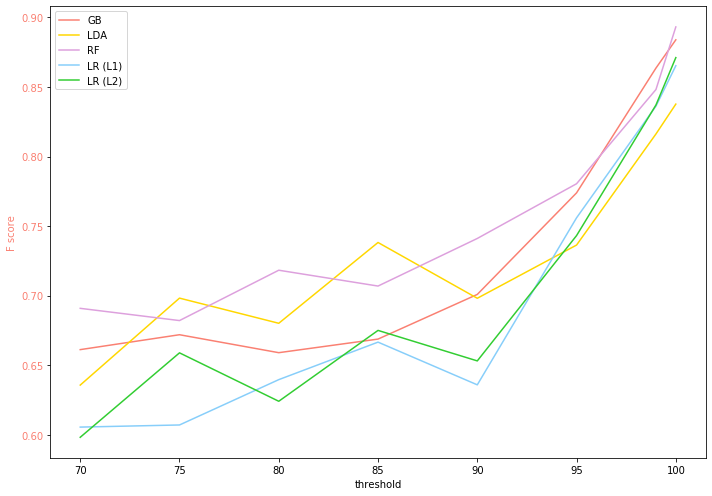

In [25]:
# F scores from the nested stratified KFold with data deletion
Fscore_CV = np.array([[0.884189, 0.826634, 0.873189, 0.832692, 0.834270], 
                      [0.856299, 0.814268, 0.834576, 0.795675, 0.808547], 
                      [0.725682, 0.729920, 0.749372, 0.719960, 0.717970], 
                      [0.664291, 0.691495, 0.712775, 0.665948, 0.677620],
                      [0.669291, 0.667032, 0.677516, 0.653282, 0.664533], 
                      [0.674215, 0.653207, 0.686817, 0.628480, 0.638571],
                      [0.645743, 0.640513, 0.663204, 0.646727, 0.635045], 
                      [0.626825, 0.627905, 0.659336, 0.597794, 0.607995]])

# F scores from the nested group KFold without data deletion
Fscore_nestedgroupkfold = np.array([[0.88394857, 0.83772996, 0.89322611, 0.86531411, 0.87116473],
       [0.86365351, 0.81627591, 0.84823543, 0.83628103, 0.83711225],
       [0.7739183 , 0.73639821, 0.78047983, 0.75598285, 0.74320604],
       [0.70090194, 0.69814207, 0.74113941, 0.6359069 , 0.65311489],
       [0.66879937, 0.73824674, 0.70692047, 0.66661055, 0.67504257],
       [0.65902354, 0.68015933, 0.71830555, 0.63964131, 0.62409165],
       [0.67193091, 0.69825193, 0.6821068 , 0.60704936, 0.65890393],
       [0.66121762, 0.63572014, 0.69090471, 0.60552125, 0.59820094]])

# Plot results together with database size
db_size = [875, 702, 449, 386, 352, 328, 309, 288]
identity_percentage = sorted([i * 100 for i in identity_threshold], reverse=True)
fig, ax1 = plt.subplots(figsize=(10,7))
colors = ['salmon', 'gold', 'plum', 'lightskyblue', 'limegreen']
models = ['GB', 'LDA', 'RF', 'LR (L1)', 'LR (L2)', 'GB', 'LDA', 'RF', 'LR (L1)', 'LR (L2)']

for i, item in enumerate(Fscore_CV.T):
    performances_i = Fscore_CV.T[i,:]
    performances_i_groupkfold = Fscore_nestedgroupkfold.T[i,:]
    #ax1.plot(identity_percentage, performances_i, color=colors[i], linewidth=3)
    ax1.plot(identity_percentage, performances_i_groupkfold, color=colors[i])

#ax1.set_ylim(0.5, 1)
ax1.set_xlabel('threshold')
ax1.set_ylabel('F score', color = 'salmon')
ax1.tick_params(axis='y', labelcolor='salmon')
ax1.legend(models)

#ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
#ax2.set_ylabel('Number of sequences', color='grey')
#ax2.plot(identity_percentage, db_size, linestyle='--', linewidth=3, color='grey')
#ax2.tick_params(axis='y', labelcolor='grey')

fig.tight_layout()
fig.savefig('results_NestedGroupKFold_plot.png', dpi=400)

##### Further examine best performing model with confusion matrix

In [70]:
features['class'] = np.asarray(dummies)
features_array = features.values
groups_array = RBP_f.define_groups(alignment_scores, threshold=0.90)
classes = [dummies.count(0), dummies.count(1), dummies.count(2), dummies.count(3), dummies.count(4), 
           dummies.count(5), dummies.count(6)]
probs = NestedGroupKFoldProba(model=pipe_rf, X=features_array[:, :-1], y=features_array[:,-1], 
                                   parameter_grid=param_grid_rf, groups=groups_array, class_weights=classes)

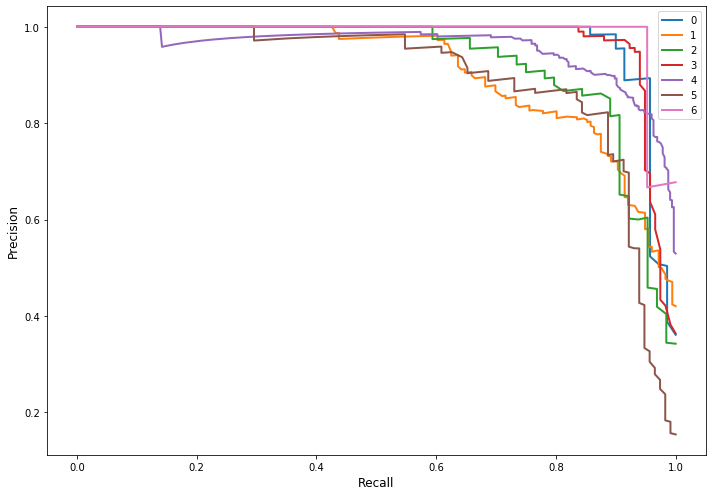

In [69]:
# AVERAGE PR CURVE VOOR ELKE THRESHOLD?
fig = multiclass_precision_recall(y_true=features_array[:,-1], probas_pred=probs, 
                                         classes=[0, 1, 2, 3, 4, 5, 6], make_plot=True)

##### Train model with different subsets of features

## 4. Feature importance

##### Feature importance with all features using GB model

In [25]:
# standardize features first
features_standardized = features.copy()
scaler = StandardScaler().fit_transform(features_standardized)
features_standardized.loc[:,:] = scaler

# with gradient boosting model
gb_all_data = GradientBoostingClassifier()
features_standardized['class'] = np.asarray(dummies)
gb_all_data.fit(features_standardized.iloc[:,:-1], features_standardized.iloc[:,-1])
importance_gb = gb_all_data.feature_importances_
importance_gb /= importance_gb.std()

# Print feats that are most important
print('important features in GB: \n', features_standardized.iloc[0:0, importance_gb>2])
l=[i for i, item in enumerate(importance_gb) if item > 2]
l

/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


important features in GB: 
 Empty DataFrame
Columns: [ATA, TTA, TAT_b, A, K, frac_aliphatic, CTDC1, Z1]
Index: []


[12, 60, 120, 133, 141, 159, 171, 213]

Text(0.5,0,'nucleotide freq., GC-content & codon freq.                        codon usage bias                                     AA freq., protein char. & 2nd struct.              ')

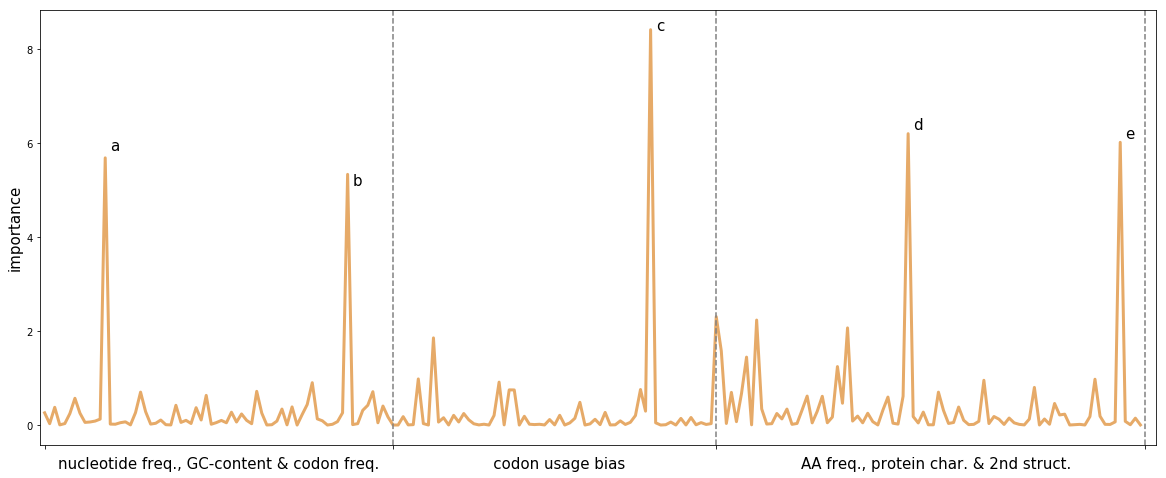

In [34]:
fig, ax1 = plt.subplots(figsize=(20,8))
ax1.plot(importance_gb[:218], color='#e6aa68', linewidth=3)
#ax1.set_title('GB importance')
ax1.set_ylabel('importance', fontsize=15)
ax1.axvline(x=69, color='grey', linestyle='--')
ax1.axvline(x=133, color='grey', linestyle='--')
ax1.axvline(x=218, color='grey', linestyle='--')
ax1.xaxis.set_major_formatter(ticker.NullFormatter())
ax1.set_xticks([0,69,133,218])
ax1.set_xlim(-1,220)
ax1.text(13, 5.85, 'a', size=15)
ax1.text(61, 5.1, 'b', size=15)
ax1.text(121, 8.4, 'c', size=15)
ax1.text(172, 6.3, 'd', size=15)
ax1.text(214, 6.1, 'e', size=15)
ax1.set_xlabel('nucleotide freq., GC-content & codon freq.                        codon usage bias                                     AA freq., protein char. & 2nd struct.              ', fontsize=15)

##### Performance of GB model with 5 most important features

In [26]:
# RUN FEATURE CONSTRUCTION (SECTION 2) & PIPELINES (SECTION 3) & SCORERS (SECTION 3) FIRST!
# train GB model with subset of 5 most important features
performances = {}
gb = GridSearchCV(pipe_gb, cv=inner_cv, param_grid=param_grid_gb, scoring=score_acc)
subset_importance = pd.concat([features.iloc[:,12], features.iloc[:,60], features.iloc[:, 120], 
                               features.iloc[:, 171], features.iloc[:, 213]], axis=1)

perf_acc = cross_val_score(gb, subset_importance, np.asarray(dummies), scoring=score_acc, cv=outer_cv, verbose=False)
perf_P = cross_val_score(gb, subset_importance, np.asarray(dummies), scoring=score_P, cv=outer_cv, verbose=False)
perf_R = cross_val_score(gb, subset_importance, np.asarray(dummies), scoring=score_R, cv=outer_cv, verbose=False)
perf_f1 = cross_val_score(gb, subset_importance, np.asarray(dummies), scoring=score_f1, cv=outer_cv, verbose=False)
performances['feats_importance'] = {'Acc':np.mean(perf_acc), 'P':np.mean(perf_P), 'R':np.mean(perf_R), 'f1':np.mean(perf_f1)}
pd.DataFrame(performances).T

/anaconda3/lib/python3.5/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The def

,Acc,P,R,f1
feats_importance,0.803012,0.815634,0.802126,0.805178


## 5. Comparing ML and BLAST

In this section, a comparison is made between a random forest model (best performing model in section 4) and BLAST. An RF model is trained and tested using a Leave-One-Group-Out CV (LOGOCV).

In [92]:
# define logocv, scorer, groups, features, lists and dicts
logo = LeaveOneGroupOut()
inner_cv = GroupKFold(n_splits=4)
score_acc = make_scorer(accuracy_score)
groups_array = RBP_f.define_groups(alignment_scores, threshold=0.50)

features_standardized = features.copy() # standardize features first
scaler = StandardScaler().fit_transform(features_standardized)
features_standardized.loc[:,:] = scaler
features_standardized['class'] = np.asarray(dummies)
X = features_standardized.iloc[:,:-1]
y = features_standardized.iloc[:,-1]

label_dict_species = {'Staphylococcus aureus': 0, 'Klebsiella pneumoniae': 1, 'Acinetobacter baumannii': 2, 'Pseudomonas aeruginosa': 3, 'Escherichia coli': 4, 'Salmonella enterica': 5, 'Clostridium difficile': 6}
label_dict_genus = {'Staphylococcus': 0, 'Klebsiella': 1, 'Acinetobacter': 2, 'Pseudomonas': 3, 'Escherichia': 4, 'Salmonella': 5, 'Clostridium': 6}
species_dict_label = {0:'Staphylococcus aureus', 1:'Klebsiella pneumoniae', 2:'Acinetobacter baumannii', 3:'Pseudomonas aeruginosa', 4:'Escherichia coli', 5:'Salmonella enterica', 6:'Clostridium difficile'}

/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [93]:
# tune hyperparameters using GridSearchCV
rf = GridSearchCV(RandomForestClassifier(), cv=inner_cv, param_grid={'n_estimators':[10, 100, 500], 
                                    'max_features': ['auto', 0.1, 0.25, 0.5]}, scoring=score_acc)
rf.fit(X,y, groups=groups_array)
best_params = rf.best_params_

In [94]:
# Perform a LOGOCV and simultaneously predict the host with BLAST
count = 0
ml_preds_list = [9]*len(dummies)
blast_preds_list = [9]*len(dummies)
probs_matrix = np.zeros((len(dummies), 7))
y_list = [9]*len(dummies)
blast_sp = 0; blast_sp_wrong = 0; blast_g = 0; blast_g_wrong = 0; ml_right = 0; ml_wrong = 0

now = time.time()
for train_ind, test_ind in logo.split(X, y, groups_array):
    X_train, X_test = X.iloc[train_ind,:], X.iloc[test_ind,:]
    y_train, y_test = y.iloc[train_ind], y.iloc[test_ind]
    
    # build model on training set
    final_model = RandomForestClassifier(class_weight='balanced')
    final_model.set_params(**best_params)
    final_model.fit(X_train, y_train)

    # make ML predictions & check correctness
    ml_preds = final_model.predict(X_test)
    ml_probs = final_model.predict_proba(X_test)
    
    # make BLAST prediction
    blast_preds = blast_local(train_ind, test_ind, fibers)
        
    # append lists to check later
    for i,index in enumerate(test_ind):
        y_list[index] = y_test[index] # both [index] because y_test is dataframe
        ml_preds_list[index] = ml_preds[i]
        probs_matrix[index,:] = ml_probs[i,:]
        blast_preds_list[index] = blast_preds[i]

    count += ml_preds.shape[0]
    print(count, ' prediction(s) done! Took ', (time.time()-now)/60, ' minutes')

# make dataframe from wrong ml predictions:
preds_comparison = pd.DataFrame({'blast_pred':blast_preds_list, 'ml_pred':ml_preds_list, 'true_label':y_list})
probs_df = pd.DataFrame(probs_matrix, columns=['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6'])
preds_comparison = pd.concat([preds_comparison, probs_df], axis=1)

17  prediction(s) done! Took  0.09558201630910237  minutes
20  prediction(s) done! Took  0.16901761690775555  minutes
57  prediction(s) done! Took  0.3164584517478943  minutes
59  prediction(s) done! Took  0.3746408502260844  minutes
84  prediction(s) done! Took  0.5288626988728841  minutes
126  prediction(s) done! Took  0.8551011323928833  minutes
131  prediction(s) done! Took  0.9488640666007996  minutes
147  prediction(s) done! Took  1.1266884843508402  minutes
154  prediction(s) done! Took  1.1908489187558493  minutes
157  prediction(s) done! Took  1.2531954328219095  minutes
165  prediction(s) done! Took  1.321828552087148  minutes
173  prediction(s) done! Took  1.4247517347335816  minutes
211  prediction(s) done! Took  1.8330987652142843  minutes
219  prediction(s) done! Took  1.8986114184061686  minutes
236  prediction(s) done! Took  2.0701700329780577  minutes
241  prediction(s) done! Took  2.123362334569295  minutes
244  prediction(s) done! Took  2.176156449317932  minutes
247

801  prediction(s) done! Took  10.20701055129369  minutes
802  prediction(s) done! Took  10.25558143456777  minutes
803  prediction(s) done! Took  10.304966350396475  minutes
804  prediction(s) done! Took  10.352234999338785  minutes
805  prediction(s) done! Took  10.401825050512949  minutes
806  prediction(s) done! Took  10.450366350015004  minutes
807  prediction(s) done! Took  10.49798493385315  minutes
808  prediction(s) done! Took  10.54800743261973  minutes
809  prediction(s) done! Took  10.599170883496603  minutes
810  prediction(s) done! Took  10.647873083750406  minutes
811  prediction(s) done! Took  10.697012901306152  minutes
812  prediction(s) done! Took  10.746740551789602  minutes
813  prediction(s) done! Took  10.79570276737213  minutes
814  prediction(s) done! Took  10.842610383033753  minutes
815  prediction(s) done! Took  10.889628167947134  minutes
816  prediction(s) done! Took  10.937912217775981  minutes
817  prediction(s) done! Took  10.99031343460083  minutes
818

In [95]:
preds_comparison.to_csv('LOGOCV_comparison_50%.csv', index=False)

### Analysis of results

##### Compute performances

In [15]:
classes = [dummies.count(0), dummies.count(1), dummies.count(2), dummies.count(3), dummies.count(4), dummies.count(5), dummies.count(6)]
#threshold_list = [70, 75, 80, 85, 90, 95, 99, 100]
threshold_list = [50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 99, 100]
f1_blast_list = []
f1_ml_list = []

for threshold in threshold_list:
    id_string = str(threshold)
    preds_comparison = pd.read_csv('LOGOCV_comparison_'+id_string+'%.csv')
    
    # compute F1 scores
    f1_blast_l = list(f1_score(preds_comparison['true_label'], preds_comparison['blast_pred'], average=None))
    f1_ml_l = list(f1_score(preds_comparison['true_label'], preds_comparison['ml_pred'], average=None))
    f1_blast = sum([a*b for a,b in zip(f1_blast_l, classes)])/sum(classes)
    f1_ml = sum([a*b for a,b in zip(f1_ml_l, classes)])/sum(classes)
    
    f1_blast_list.append(f1_blast)
    f1_ml_list.append(f1_ml)

/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined an

##### Plot weighted F1 scores

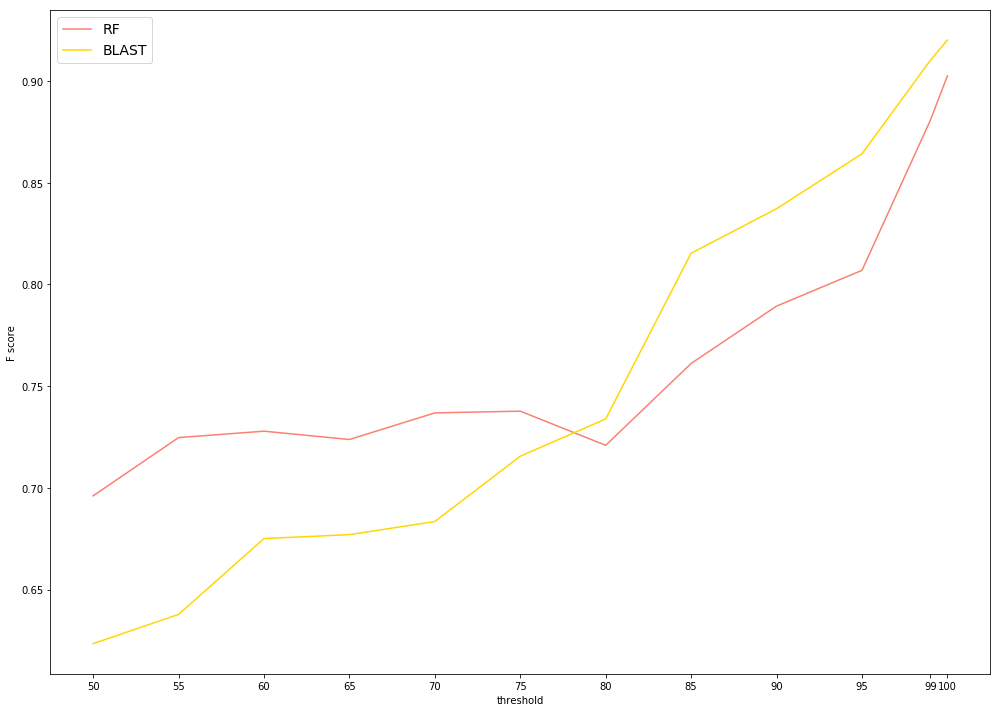

In [17]:
Fscore_LOGOCV = np.array([f1_ml_list, f1_blast_list])
fig, ax1 = plt.subplots(figsize=(14,10))
colors = ['salmon', 'gold']
models = ['RF', 'BLAST']

for i, item in enumerate(Fscore_LOGOCV):
    performances_i = Fscore_LOGOCV[i,:]
    ax1.plot(threshold_list, performances_i, color=colors[i])

ax1.set_xticks(threshold_list)
ax1.set_xlabel('threshold')
ax1.set_ylabel('F score')
ax1.legend(models, fontsize=14)

fig.tight_layout()
plt.show()
fig.savefig('results_LOGOCV_plot.png', dpi=400)

In [6]:
# confusion matrix ML predictions
cm = pd.DataFrame(confusion_matrix(preds_comparison['true_label_num'], preds_comparison['ml_pred_0.5'])) # rows actual classes; columns predicted classes
cm.rename(columns={0:'S. aureus', 1:'K. pneumoniae', 2:'A. baumannii', 3:'P. aeruginosa', 4:'E. coli',
                   5:'S. enterica', 6:'C. difficile'}, index={0:'S. aureus', 1:'K. pneumoniae', 2:'A. baumannii', 
                    3:'P. aeruginosa', 4:'E. coli', 5:'S. enterica', 6:'C. difficile'}, inplace=True)
cm

,S. aureus,K. pneumoniae,A. baumannii,P. aeruginosa,E. coli,S. enterica,C. difficile,7
S. aureus,93,0,0,0,2,1,0,0
K. pneumoniae,0,197,1,4,15,6,1,3
A. baumannii,0,1,54,2,4,0,0,8
P. aeruginosa,0,2,1,150,2,1,0,0
E. coli,3,6,2,0,378,6,0,4
S. enterica,0,4,0,0,10,130,0,4
C. difficile,0,0,0,0,0,0,42,0
7,0,0,0,0,0,0,0,0


In [9]:
# confusion matrix BLAST predictions
species = {'Staphylococcus aureus': 0, 'Klebsiella pneumoniae': 1, 'Acinetobacter baumannii': 2, 'Pseudomonas aeruginosa': 3, 'Escherichia coli': 4, 'Salmonella enterica': 5, 'Clostridium difficile': 6, 'Other': 7}
genus = {'Staphylococcus': 0, 'Klebsiella': 1, 'Acinetobacter': 2, 'Pseudomonas': 3, 'Escherichia': 4, 'Salmonella': 5, 'Clostridium': 6, 'Other': 7}

conf_matrix_BLAST_sp = np.zeros((8,8))
conf_matrix_BLAST_g = np.zeros((8,8))

for i, blast_pred in enumerate(preds_comparison['blast_pred']):
    true_sp = preds_comparison['true_label'][i]
    true_g = true_sp.split(' ')[0]
    blast_pred_g = blast_pred.split(' ')[0]
    
    # species level
    row = species[true_sp]
    if blast_pred in species.keys():
        column = species[blast_pred]
    else:
        column = species['Other']
    conf_matrix_BLAST_sp[row, column] += 1
    
    # genus level
    row = genus[true_g]
    if blast_pred_g in genus.keys():
        column = genus[blast_pred_g]
    else:
        column = genus['Other']
    conf_matrix_BLAST_g[row, column] += 1

cm_sp = pd.DataFrame(conf_matrix_BLAST_sp.astype(int))
cm_g = pd.DataFrame(conf_matrix_BLAST_g.astype(int))
cm_sp.rename(columns={0:'S. aureus', 1:'K. pneumoniae', 2:'A. baumannii', 3:'P. aeruginosa', 4:'E. coli',
                   5:'S. enterica', 6:'C. difficile', 7: 'Other'}, index={0:'S. aureus', 1:'K. pneumoniae', 2:'A. baumannii', 
                    3:'P. aeruginosa', 4:'E. coli', 5:'S. enterica', 6:'C. difficile', 7: 'Other'}, inplace=True)
cm_g.rename(columns={0:'Staphylococcus', 1:'Klebsiella', 2:'Acinetobacter', 3:'Pseudomonas', 4:'Escherichia',
                   5:'Salmonella', 6:'Clostridium', 7: 'Other'}, index={0:'Staphylococcus', 1:'Klebsiella', 2:'Acinetobacter', 
                    3:'Pseudomonas', 4:'Escherichia', 5:'Salmonella', 6:'Clostridium', 7: 'Other'}, inplace=True)

In [10]:
cm_g

,Staphylococcus,Klebsiella,Acinetobacter,Pseudomonas,Escherichia,Salmonella,Clostridium,Other
Staphylococcus,90,0,0,0,2,2,0,2
Klebsiella,0,202,0,0,14,1,0,10
Acinetobacter,0,0,62,0,1,0,0,6
Pseudomonas,0,0,0,151,0,0,0,5
Escherichia,0,2,0,0,324,15,1,57
Salmonella,2,0,0,0,7,134,0,5
Clostridium,0,0,0,0,0,0,42,0
Other,0,0,0,0,0,0,0,0


In [11]:
cm_sp

,S. aureus,K. pneumoniae,A. baumannii,P. aeruginosa,E. coli,S. enterica,C. difficile,Other
S. aureus,42,0,0,0,2,1,0,51
K. pneumoniae,0,148,0,0,13,1,0,65
A. baumannii,0,0,42,0,1,0,0,26
P. aeruginosa,0,0,0,116,0,0,0,40
E. coli,0,2,0,0,244,10,1,142
S. enterica,2,0,0,0,4,89,0,53
C. difficile,0,0,0,0,0,0,42,0
Other,0,0,0,0,0,0,0,0


## TEST

In [ ]:
# calculate ROC AUC scores
features['class'] = np.asarray(dummies) # add target column
features_array = features.values
X = features_array[:, :-1]
y = features_array[:,-1]
outer_cv = GroupKFold(n_splits=4)
n_splits_outer = outer_cv.get_n_splits()
perf_auc = []
perf_f1 = []
    
for train_outer, test_outer in outer_cv.split(X, y, groups_array):
    X_train, X_test = X[train_outer], X[test_outer]
    y_train, y_test = y[train_outer], y[test_outer]
    groups_train, groups_test = groups_array[train_outer], groups_array[test_outer]
    
    pipe_lda.fit(X_train, y_train)
    y_preds = pipe_lda.predict(X_test)
    y_prob = pipe_lda.predict_proba(X_test)
    
    auc_sc = roc_auc_score(y_true=y_test, y_score=y_prob, average='weighted', multi_class='ovo')
    f1_sc = f1_score(y_true=y_test, y_pred=y_preds, average='weighted')
    perf_auc.append(auc_sc)
    perf_f1.append(f1_sc)

In [7]:
# Check identicals
count = 0
for i in range(fibers.shape[0]):
    sequence1 = list(fibers['protein_sequence'])[i]
    for j in range(i, fibers.shape[0]):
        sequence2 = list(fibers['protein_sequence'])[j]
        if (sequence1 == sequence2) & (i != j):
            count += 1
            print(i, ' and ', j)
            print(fibers.iloc[i,0], fibers.iloc[i,6], fibers.iloc[i,7],fibers.iloc[i,8])
            print(fibers.iloc[j,0], fibers.iloc[j,6], fibers.iloc[j,7],fibers.iloc[j,8])
            print('---') 

2  and  105
P12528 Bacteriophage P22 Salmonella enterica 667
A0A161HB76 Salmonella phage 118970_sal4 Salmonella enterica 667
---
2  and  111
P12528 Bacteriophage P22 Salmonella enterica 667
A0A192Y7Q2 Salmonella phage 64795_sal4 Salmonella enterica 667
---
2  and  114
P12528 Bacteriophage P22 Salmonella enterica 667
A0A192Y7D2 Salmonella phage 146851_sal5 Salmonella enterica 667
---
2  and  115
P12528 Bacteriophage P22 Salmonella enterica 667
A0A192Y8R8 Salmonella phage 103203_sal5 Salmonella enterica 667
---
2  and  119
P12528 Bacteriophage P22 Salmonella enterica 667
A0A192Y718 Salmonella phage 101962B_sal5 Salmonella enterica 667
---
2  and  161
P12528 Bacteriophage P22 Salmonella enterica 667
A0A2C6YAT2 Salmonella typhimurium Salmonella enterica 667
---
2  and  168
P12528 Bacteriophage P22 Salmonella enterica 667
A0A192Y669 Salmonella phage 146851_sal4 Salmonella enterica 667
---
22  and  71
Q06EG7 Bacteriophage RB32 Escherichia coli 516
A0A097J6K3 Enterobacteria phage RB33 Escheri

108  and  176
A0A097J4K6 Bacteriophage RB9 Escherichia coli 1289
A0A097J232 Enterobacteria phage RB5 Escherichia coli 1289
---
108  and  192
A0A097J4K6 Bacteriophage RB9 Escherichia coli 1289
A0A097J587 Bacteriophage RB10 Escherichia coli 1289
---
108  and  197
A0A097J4K6 Bacteriophage RB9 Escherichia coli 1289
A0A097J1C1 Bacteriophage RB3 Escherichia coli 1289
---
108  and  217
A0A097J4K6 Bacteriophage RB9 Escherichia coli 1289
A0A097J3P4 Enterobacteria phage RB7 Escherichia coli 1289
---
110  and  739
A0A2D1GPH4 Staphylococcus phage SAJK-IND Staphylococcus aureus 207
ATN93927.1 Staphylococcus phage SAJK-IND Staphylococcus aureus 207
---
111  and  114
A0A192Y7Q2 Salmonella phage 64795_sal4 Salmonella enterica 667
A0A192Y7D2 Salmonella phage 146851_sal5 Salmonella enterica 667
---
111  and  115
A0A192Y7Q2 Salmonella phage 64795_sal4 Salmonella enterica 667
A0A192Y8R8 Salmonella phage 103203_sal5 Salmonella enterica 667
---
111  and  119
A0A192Y7Q2 Salmonella phage 64795_sal4 Salmonella

245  and  601
A0A0A8JBQ8 Klebsiella phage K64-1 Klebsiella pneumoniae 702
BAQ02837.1 Klebsiella phage K64-1 Klebsiella pneumoniae 702
---
245  and  623
A0A0A8JBQ8 Klebsiella phage K64-1 Klebsiella pneumoniae 702
YP_009153197.1 Klebsiella phage K64-1 Klebsiella pneumoniae 702
---
246  and  441
A0A0A8J9A5 Klebsiella phage K64-1 Klebsiella pneumoniae 1193
YP_009153198.1 Klebsiella phage K64-1 Klebsiella pneumoniae 1193
---
246  and  575
A0A0A8J9A5 Klebsiella phage K64-1 Klebsiella pneumoniae 1193
BAQ02838.1 Klebsiella phage K64-1 Klebsiella pneumoniae 1193
---
247  and  338
A0A0A8J9V7 Klebsiella phage K64-1 Klebsiella pneumoniae 584
YP_009153199.1 Klebsiella phage K64-1 Klebsiella pneumoniae 584
---
247  and  641
A0A0A8J9V7 Klebsiella phage K64-1 Klebsiella pneumoniae 584
BAQ02839.1 Klebsiella phage K64-1 Klebsiella pneumoniae 584
---
248  and  564
A0A0A8J8T2 Klebsiella phage K64-1 Klebsiella pneumoniae 888
YP_009153201.1 Klebsiella phage K64-1 Klebsiella pneumoniae 888
---
248  and  630


319  and  730
YP_009226010.1 Klebsiella phage KP36 Klebsiella pneumoniae 1233
AEX26806.1 Klebsiella phage KP36 Klebsiella pneumoniae 1233
---
326  and  515
ADE35063.1 Klebsiella phage KP15 Klebsiella pneumoniae 1257
YP_003580107.1 Klebsiella phage KP15 Klebsiella pneumoniae 1257
---
330  and  734
YP_003347643.1 Klebsiella phage KP34 Klebsiella pneumoniae 307
ACY66723.1 Klebsiella phage KP34 Klebsiella pneumoniae 307
---
331  and  481
AKO62090.1 Staphylococcus phage 55-3 Staphylococcus aureus JP8362 607
AKO62025.1 Staphylococcus phage 55-2 Staphylococcus aureus JP8361 607
---
336  and  454
A0A125RP82 Pseudomonas phage K5 Pseudomonas aeruginosa 670
A0A0N9ELN9 Pseudomonas phage K8 Pseudomonas aeruginosa 670
---
338  and  641
YP_009153199.1 Klebsiella phage K64-1 Klebsiella pneumoniae 584
BAQ02839.1 Klebsiella phage K64-1 Klebsiella pneumoniae 584
---
339  and  391
YP_003347555.1 Klebsiella phage KP32 Klebsiella pneumoniae 869
ACY66699.1 Klebsiella phage KP32 Klebsiella pneumoniae 869
---


430  and  467
QBI77395.1 Pseudomonas phage CF54 Pseudomonas aeruginosa 1221
QBI78311.1 Pseudomonas phage BR161 Pseudomonas aeruginosa 1221
---
430  and  476
QBI77395.1 Pseudomonas phage CF54 Pseudomonas aeruginosa 1221
QBI78009.1 Pseudomonas phage CF183 Pseudomonas aeruginosa 1221
---
430  and  654
QBI77395.1 Pseudomonas phage CF54 Pseudomonas aeruginosa 1221
QBI78251.1 Pseudomonas phage BR143 Pseudomonas aeruginosa 1221
---
430  and  657
QBI77395.1 Pseudomonas phage CF54 Pseudomonas aeruginosa 1221
QBI77312.1 Pseudomonas phage CF53 Pseudomonas aeruginosa 1221
---
430  and  670
QBI77395.1 Pseudomonas phage CF54 Pseudomonas aeruginosa 1221
QBI78131.1 Pseudomonas phage BR52 Pseudomonas aeruginosa 1221
---
430  and  683
QBI77395.1 Pseudomonas phage CF54 Pseudomonas aeruginosa 1221
QBI78371.1 Pseudomonas phage BR178 Pseudomonas aeruginosa 1221
---
430  and  685
QBI77395.1 Pseudomonas phage CF54 Pseudomonas aeruginosa 1221
QBI77756.1 Pseudomonas phage CF127 Pseudomonas aeruginosa 1221
---
4

670  and  683
QBI78131.1 Pseudomonas phage BR52 Pseudomonas aeruginosa 1221
QBI78371.1 Pseudomonas phage BR178 Pseudomonas aeruginosa 1221
---
670  and  685
QBI78131.1 Pseudomonas phage BR52 Pseudomonas aeruginosa 1221
QBI77756.1 Pseudomonas phage CF127 Pseudomonas aeruginosa 1221
---
678  and  736
YP_003857091.1 Staphylococcus virus SAP26 Staphylococcus aureus 412
ADL66954.1 Staphylococcus virus SAP26 Staphylococcus aureus 412
---
683  and  685
QBI78371.1 Pseudomonas phage BR178 Pseudomonas aeruginosa 1221
QBI77756.1 Pseudomonas phage CF127 Pseudomonas aeruginosa 1221
---
712  and  718
AUS03394.1 Staphylococcus phage vB_SauP_phiAGO1.9 Staphylococcus aureus 298
AUS03379.1 Staphylococcus phage vB_SauP_phiAGO1.3 Staphylococcus aureus 298
---
743  and  747
AEF56895.1 Clostridium phage phiCD38-2 Clostridium difficile 820
YP_004508398.1 Clostridium phage phiCD38-2 Clostridium difficile 820
---
745  and  772
YP_009202008.1 Clostridium phage phiCD506 Clostridium difficile 303
CEK40722.1 Clost

826  and  1068
A0A166LU71 Salmonella phage f3SE Salmonella enterica serovar Enteritidis 852
A0A0S2GLN2 Salmonella phage fSE1C Salmonella enterica 852
---
843  and  1026
U5PYC0 Salmonella phage Marshall Salmonella enterica 742
A0A385IPL9 Salmonella phage Mooltan Salmonella enterica serovar Enteritidis 742
---
848  and  1084
A0A097J1G8 Enterobacteria phage RB3 Escherichia coli B 1030
A0A097J2W0 Enterobacteria phage RB6 Escherichia coli B 1030
---
848  and  1107
A0A097J1G8 Enterobacteria phage RB3 Escherichia coli B 1030
A0A097J264 Enterobacteria phage RB5 Escherichia coli B 1030
---
851  and  881
A0A0N7BU72 Escherichia phage PA32 Escherichia coli PA32 645
A0A0N7C182 Escherichia phage PA16 Escherichia coli PA16 645
---
851  and  900
A0A0N7BU72 Escherichia phage PA32 Escherichia coli PA32 645
A0A0P0ZD84 Stx2-converting phage Stx2a_F403 Escherichia coli O157:H7 strain F403 645
---
851  and  936
A0A0N7BU72 Escherichia phage PA32 Escherichia coli PA32 645
A0A0N7C2X2 Escherichia phage PA29 Esc

922  and  1066
A0A2Z5HP35 Salmonella phage S131 Salmonella enterica serotype Enteritidis E2331 685
A0A2Z5HNP9 Salmonella phage S130 Salmonella enterica serotype Enteritidis E2331 685
---
927  and  1062
A0A0F6R8R7 Escherichia coli O157 typing phage 11 Escherichia coli O157:H7 391
A0A0F6TL01 Escherichia coli O157 typing phage 15 Escherichia coli O157:H7 391
---
934  and  940
A0A0S1WHB4 Pseudomonas phage Triton Pseudomonas aeruginosa 964
A0A0S1WGL0 Pseudomonas phage Nessie Pseudomonas aeruginosa 964
---
934  and  965
A0A0S1WHB4 Pseudomonas phage Triton Pseudomonas aeruginosa 964
A0A0S1WHA8 Pseudomonas phage Smee Pseudomonas aeruginosa 964
---
934  and  1035
A0A0S1WHB4 Pseudomonas phage Triton Pseudomonas aeruginosa 964
A0A0S1WG51 Pseudomonas phage Kula Pseudomonas aeruginosa 964
---
934  and  1065
A0A0S1WHB4 Pseudomonas phage Triton Pseudomonas aeruginosa 964
A0A0S1WFM0 Pseudomonas phage Jollyroger Pseudomonas aeruginosa 964
---
936  and  984
A0A0N7C2X2 Escherichia phage PA29 Escherichia 

1020  and  1047
A0A0N7BUI8 Escherichia phage PA36 Escherichia coli PA36 645
E7DYX2 Enterobacteria phage VT2phi_272 Escherichia coli O157:H7 strain 71074 645
---
1020  and  1092
A0A0N7BUI8 Escherichia phage PA36 Escherichia coli PA36 645
A0A0N7C1I1 Escherichia phage PA21 Escherichia coli PA21 645
---
1020  and  1099
A0A0N7BUI8 Escherichia phage PA36 Escherichia coli PA36 645
Q7Y2W1 Escherichia phage Stx2 II Escherichia coli O157:H7 Morioka V526 645
---
1022  and  1023
A0A0N6WES8 Escherichia phage PA28 Escherichia coli PA28 645
A0A0N7C142 Escherichia phage PA42 Escherichia coli PA42 645
---
1022  and  1047
A0A0N6WES8 Escherichia phage PA28 Escherichia coli PA28 645
E7DYX2 Enterobacteria phage VT2phi_272 Escherichia coli O157:H7 strain 71074 645
---
1022  and  1092
A0A0N6WES8 Escherichia phage PA28 Escherichia coli PA28 645
A0A0N7C1I1 Escherichia phage PA21 Escherichia coli PA21 645
---
1022  and  1099
A0A0N6WES8 Escherichia phage PA28 Escherichia coli PA28 645
Q7Y2W1 Escherichia phage St

###### Clustermap of alignment identities

In [ ]:
# cluster map
color = []
for i, cl in enumerate(dummies):
    if i == 0:
        color.append('salmon')
    elif i == 1:
        color.append('gold')
    elif i == 2:
        color.append('plum')
    elif i == 3:
        color.append('lightskyblue')
    elif i == 4:
        color.append('limegreen')
    elif i == 5:
        color.append('firebrick')
    elif i == 6:
        color.append('royalblue')
        
plt.figure(figsize=(14,14))
fig = sns.clustermap(thres, row_colors=color, col_colors=color)
#plt.savefig('alignments_clustermap.png', dpi=400)

In [ ]:
plt.figure(figsize=(14,14))
fig = sns.clustermap(thres, row_colors=color, col_colors=color)
#plt.savefig('alignments_clustermap.png', dpi=400)